In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import sklearn as sk
import os
import random
import math


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
IMG_SIZE = 224

PATH = "video_data/surveillance_dataset/"

In [4]:
def video_to_frames(p):
    #assert os.path.exists(p)
    cap = cv2.VideoCapture(p)
    
    #assert cap
    rate = math.floor(cap.get(3))

    ImageFrames = []
    #assert cap.isOpened()
    

    '''make sure to figure out how to extract a certain amount of frames so you don't use too much memory'''
    while cap.isOpened():
        #ID = cap.get(1)
        
        success, image = cap.read()
        n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        mid = int(n_frames/2)
        first_q = int(n_frames/4)
        third_q = int(n_frames * .75)
        end = n_frames
        #print(n_frames)
        #assert success

        if success:

            for frame in range(n_frames):
                if frame == first_q or frame == mid or frame == third_q or frame == end:
                    
                    
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    ImageFrames.append(image)
                else: continue
            cap.release()
    #print("successful frame capture")
            return ImageFrames

        else: 
            break

In [5]:
CATEGORIES = ["fight", "noFight"]
X_set = []
y_set = []
for category in os.listdir(PATH):
    
    
    path = os.path.join(PATH, category)
    #print(path)
    #assert os.path.exists(path)


    class_num = CATEGORIES.index(category)
    for i, video in tqdm(enumerate(os.listdir(path)), total=len(os.listdir(path))):

        #print(path + '/' + video)
        #print(os.path.join(path, video))
        frames = video_to_frames(path + '/' + video)
        if frames:
        
            for j, frame in enumerate(frames):
                X_set.append(frame)
                y_set.append(class_num)
        else: continue

            
print("success")

100%|██████████| 150/150 [00:03<00:00, 38.89it/s]

success


In [6]:
X_set = np.array(X_set).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_set = np.array(y_set)
len(X_set), len(y_set)

(900, 900)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.2)

for train_index, test_index in stratified_sample.split(X_set, y_set):
    X_train, X_test = X_set[train_index], X_set[test_index]
    y_train, y_test = y_set[train_index], y_set[test_index]

In [8]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
# X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

y_train = np.asarray(y_train)
y_test_nn = np.asarray(y_test)
# y_val = np.asarray(y_val)

In [9]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train, y_train, 16)
test_gen = DataGenerator(X_test_nn, y_test_nn, 16)
# val_gen = DataGenerator(X_val, y_val, 16)

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet import preprocess_input

In [11]:
from tensorflow.keras import Sequential, layers

# data_augmentation = Sequential(
#     [
#         layers.RandomFlip("horizontal_and_vertical"),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#         layers.RandomContrast(factor=0.1),
#         layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#     ],
#     name="img_augmentation"
# )
data_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation"
)

In [12]:
def build_model(input_shape, data_aug, trainable=True, dropout=0.5):
        inputs = keras.Input(shape=input_shape)
        x = data_aug(inputs)
        x = preprocess_input(x)

        baseModel = MobileNetV2(weights=None, 
                                   pooling='avg',
                                   include_top=False, 
                                   input_tensor=x)
        baseModel.trainable = trainable

        headModel = baseModel.output
        #headModel = layers.GlobalAveragePooling2D()(headModel)
        headModel = layers.Dropout(dropout)(headModel)
        outputs = layers.Dense(1, activation="sigmoid")(headModel)
        model = Model(inputs, outputs)

        return model

In [14]:
MobNet = build_model(input_shape=(224,224) + (3,),
                     data_aug= data_augmentation,
                     trainable=True,
                     dropout=0.3)

In [15]:
from keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.0001)
    
]

In [16]:
mets = ['binary_accuracy', 'acc']
MobNet.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
               metrics=mets)


In [17]:
history = MobNet.fit(train_gen,
                     batch_size=16,
                     epochs=25, 
                     steps_per_epoch= len(train_gen),
                    #  callbacks= callbacks,
                     #validation_data=val_gen,                    
                     verbose=1)

print("Training Complete.")

Epoch 1/25
45/45 [==============================] - 19s 112ms/step - loss: 0.7154 - binary_accuracy: 0.4931 - acc: 0.4931
Epoch 2/25
45/45 [==============================] - 5s 111ms/step - loss: 0.7037 - binary_accuracy: 0.5292 - acc: 0.5292
Epoch 3/25
45/45 [==============================] - 5s 114ms/step - loss: 0.7164 - binary_accuracy: 0.5125 - acc: 0.5125
Epoch 4/25
45/45 [==============================] - 5s 113ms/step - loss: 0.7009 - binary_accuracy: 0.5222 - acc: 0.5222
Epoch 5/25
45/45 [==============================] - 5s 112ms/step - loss: 0.7043 - binary_accuracy: 0.5236 - acc: 0.5236
Epoch 6/25
45/45 [==============================] - 5s 112ms/step - loss: 0.7108 - binary_accuracy: 0.5361 - acc: 0.5361
Epoch 7/25
45/45 [==============================] - 5s 113ms/step - loss: 0.7275 - binary_accuracy: 0.4653 - acc: 0.4653
Epoch 8/25
45/45 [==============================] - 5s 114ms/step - loss: 0.6935 - binary_accuracy: 0.5389 - acc: 0.5389
Epoch 9/25
45/45 [=============

In [19]:
def eval_model(model):
    acc = model.evaluate(test_gen)
    print("This model's accuracy is:", round(acc[1], 4)*100 , "%")


eval_model(MobNet)

12/12 [==============================] - 2s 52ms/step - loss: 0.6937 - binary_accuracy: 0.5000 - acc: 0.5000
This model's accuracy is: 50.0 %


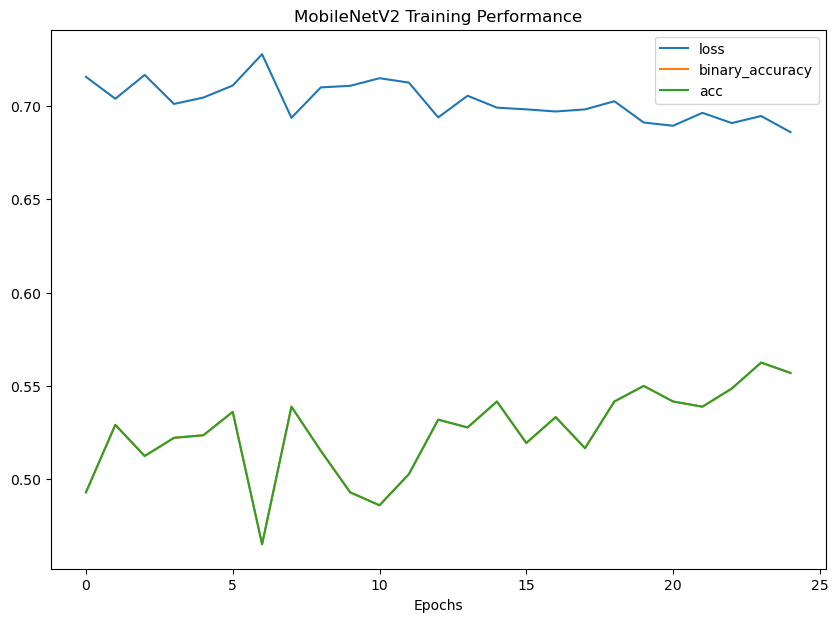

In [20]:
def view_performance(model_hist):
    graph = pd.DataFrame(model_hist.history).plot(figsize=(10,7), title="MobileNetV2 Training Performance", xlabel="Epochs")



view_performance(history)